# Solid Earth tides - time series and frequency aliasing

In [1]:
%matplotlib inline
import os
import datetime as dt
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt, ticker, dates as mdates
import pysolid
from mintpy.utils import utils as ut, isce_utils
plt.rcParams.update({'font.size': 12})

work_dir = os.path.expanduser('~/Papers/2022_Geolocation/figs_src/SET')
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/Papers/2021_Geolocation/figs_src/SET


## Fig:SET - Calculate

In [19]:
## SET time-series
# inputs
lat, lon = 34.0, -118.0 # Los Angles, CA
step_sec = 60 * 30
dt0 = dt.datetime(2019,12,1,0,0,0)
dt1 = dt.datetime(2021,2,1,0,0,0)

# run
(dt_out,
 tide_e,
 tide_n,
 tide_u) = pysolid.calc_solid_earth_tides_point(lat, lon, dt0, dt1,
                                                step_sec=step_sec,
                                                display=False,
                                                verbose=False)

# tide: ENU2LOS
inc_angle = 42 * np.pi / 180.
az_angle = 100 * np.pi / 180.
tide_los = ut.enu2los(tide_e, tide_n, tide_u, inc_angle=inc_angle, az_angle=az_angle)

# SET time-series at SAR acquisitions
dt_sen12 = np.array([dt.datetime(2019, 9, 3, 13, 30, 0) + dt.timedelta(days=12) * i for i in range(-200,200)])
dt_sen06 = np.array([dt.datetime(2019, 9, 3, 13, 30, 0) + dt.timedelta(days=6)  * i for i in range(-400,400)])
tide_sen12 = np.array([tide_los[dt_out==d] for d in dt_sen12 if np.sum(dt_out==d) > 0], dtype=np.float32)
tide_sen06 = np.array([tide_los[dt_out==d] for d in dt_sen06 if np.sum(dt_out==d) > 0], dtype=np.float32)
# remove zero values
dt_sen12 = dt_sen12[np.multiply(dt_sen12>=dt0, dt_sen12<=dt1)]
dt_sen06 = dt_sen06[np.multiply(dt_sen06>=dt0, dt_sen06<=dt1)]

print('Done.')

PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.0/-118.0 degree
PYSOLID: start UTC: 2019-12-01T00:00:00
PYSOLID: end   UTC: 2021-02-01T00:00:00
PYSOLID: time step: 1800 seconds
Done.


## Fig:SET - Plot time-series of SET up components

save figure to file: /Users/yunjunz/Papers/2021_Geolocation/figs_src/SET/SET_TS.pdf


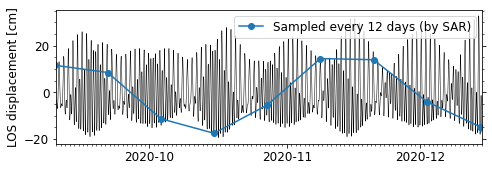

In [29]:
# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7, 2.5])
ax.plot(dt_out, tide_u*100, lw=0.5, c='k')
ax.plot(dt_sen12, tide_sen12*100, 'o-', c='C0', label='Sampled every 12 days (by SAR)')
#ax.plot(dt_sen06, tide_sen06*100, 'o-', c='C1', mfc='none', label='Sampled every 6 days')

# axis format
ax.tick_params(which='both', direction='out', bottom=True, top=False, left=True, right=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_ylabel('LOS displacement [cm]')
ax.set_xlim(dt.datetime(2020,9,10), dt.datetime(2020,12,15))
#ax.set_ylim(-22, 40)
ax.legend(loc='upper right', ncol=2)
fig.tight_layout()

# output
out_fig = os.path.abspath('SET_TS.pdf')
print('save figure to file:', out_fig)
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

## Fig:SET - Plot power spectrum in semi-diurnal and diurnal periods

save figure to file: /Users/yunjunz/Papers/2021_Geolocation/figs_src/SET_PSD.pdf


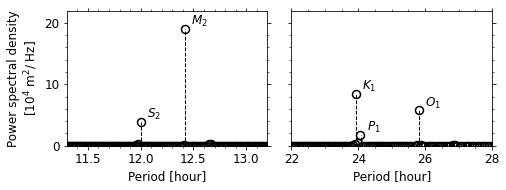

In [4]:
## calc PSD
fs = 1. / step_sec
freq, psd = signal.periodogram(tide_los, fs=fs, scaling='density')
# get rid of zero in the first element
psd = psd[1:] / 1e4
freq = freq[1:]
period = 1./3600./freq   # period (hour)

## plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[7.2, 2.8], sharey=True)
for ax in axs:
    ax.plot(period, psd, 'ko', ms=8, mfc='none', mew=1.5)

# axis format
for ax in axs:
    ax.tick_params(which='both', direction='out', bottom=True, top=True, left=True, right=True)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_xlabel('Period [hour]')
axs[0].set_xlim(11.3, 13.2)
axs[1].set_xlim(22.0, 28.0)
ax = axs[0]
ax.set_ylabel('Power spectral density\n'+r'[$10^4$ '+r'm$^2/$ Hz]')
ax.set_ylim(0, ymax=axs[0].get_ylim()[1] * 1.1)
ax.yaxis.set_major_locator(ticker.FixedLocator([0,10,20]))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
fig.tight_layout()

# Tidal constituents
for ax in axs:  pysolid.add_tidal_constituents(ax, period, psd, min_psd=0.4)

# output
out_fig = 'SET_PSD.pdf'
print('save figure to file:', os.path.abspath(out_fig))
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

## Frequency Aliasing

In [7]:
t_m2 = 12.4206012 * 3600 # seconds, period of M2 tide
t_sen = 6 * 24 * 3600   # seconds, sampling interval of Sentinel-1 and NISAR
f_m2 = 1000. / t_m2      # mHz
f_sen = 1000. / t_sen    # mHz
print(f'Signal frequency [mHz]: {f_m2}')
print(f'Sampling rate    [mHz]: {f_sen}')

N = np.rint(f_m2 / f_sen)
f_alias = np.abs(N * f_sen - f_m2)
t_alias = (1000. / f_alias) / (24 * 3600)
print(f'Alias  frequency [mHz]: {f_alias} -> {t_alias:.2f} days')

Signal frequency [mHz]: 0.02236427796891005
Sampling rate    [mHz]: 0.0019290123456790122
Alias  frequency [mHz]: 0.0007838701792380956 -> 14.77 days


## Impact of SAR Acquuisition Time Variation

In [6]:
tide_los_max_rate = np.max(np.abs(np.diff(tide_los) / step_sec)) * 1000 * 60
print('max LOS SET rate: {:.1f} mm/min'.format(tide_los_max_rate))

xml_file = os.path.expanduser('~/data/geolocation/ChileSenAT149/reference/IW2.xml')
meta, burst = isce_utils.extract_isce_metadata(xml_file)
Vs = float(meta['satelliteSpeed'])
Re = float(meta['earthRadius'])
Hs = float(meta['altitude'])
Vg = Vs * Re / (Re + Hs)
print('Satellite speed on orbit / ground: {:.1f} / {:.1f} m/s'.format(Vs, Vg))

t = 100e3 / Vg
ramp = tide_los_max_rate * (t / 60)
print('Time to image 100 km: {:.1f}'.format(t))
print('SET ramp in the along-track direction: {:.1f} mm / 100km'.format(ramp))

max LOS SET rate: 1.9 mm/min
extract metadata from ISCE/topsStack xml file: /Users/yunjunz/data/geolocation/ChileSenAT149/reference/IW2.xml
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Satellite speed on orbit / ground: 7590.2 / 6831.6 m/s
Time to image 100 km: 14.6
SET ramp in the along-track direction: 0.5 mm / 100km
